In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from UNetDataGenerator import NucleiDataGenerator
from Unet import Unet

#### Define Implementation details, Dataset criteria and Model hyper parameters

In [2]:
image_size = 256
image_channels = 3
image_dir = "data-science-bowl-2018/stage1_train/"
epochs = 20
batch_size = 8

validation_data_size = 50
test_data_size = 20
train_data_size = 600

#### Define Reusable Methods

In [3]:
def VisualizeImageAndMask(image, mask, prediction_img = None):

    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)
    setTitleAndRemoveTicks(ax, 'Microscopic\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(mask, (image_size, image_size)), cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):

    axes.title.set_text(title)

    axes.set_xticks([])
    axes.set_yticks([])

#### Define Train, Test and Validation sets

In [4]:
image_ids = next(os.walk(image_dir))[1]

testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

#### Sample Data Visualization

In [5]:
temp_data_generator = NucleiDataGenerator(image_ids = training_data_ids, 
                                          img_path = image_dir, 
                                          batch_size = batch_size, 
                                          image_size = image_size)

images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (8, 256, 256, 3) (8, 256, 256, 1)


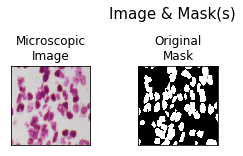

In [6]:
VisualizeImageAndMask(image = images[2], mask = masks[2])

In [7]:
temp_data_generator = None

### Model Training and Validation

#### Create UNet Model 

In [8]:
unet = Unet(input_shape = (image_size, image_size, image_channels), 
            filters = [16, 32, 64, 128, 256], 
            padding = "same")

model = unet.Build_UNetwork()

In [9]:
if model is not None:
    unet.CompileAndSummarizeModel(model = model)

Model: "UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 16) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

#### Data Generators

In [10]:
train_gen = NucleiDataGenerator(image_ids = training_data_ids, 
                                img_path = image_dir, 
                                image_size = image_size, 
                                batch_size = batch_size)

valid_gen = NucleiDataGenerator(image_ids = validation_data_ids, 
                                img_path = image_dir, 
                                image_size = image_size, 
                                batch_size = batch_size)

test_gen = NucleiDataGenerator(image_ids = testing_data_ids, 
                               img_path = image_dir, 
                               image_size = image_size, 
                               batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

#### Model Training

In [11]:
model.fit(train_gen, 
          validation_data = valid_gen, 
          steps_per_epoch = train_steps, 
          validation_steps = valid_steps, 
          epochs = epochs)

Epoch 1/20
75/75 [==============================] - 348s 5s/step - loss: 0.3992 - acc: 0.8521 - val_loss: 0.2833 - val_acc: 0.8467
Epoch 2/20
75/75 [==============================] - 194s 3s/step - loss: 0.2117 - acc: 0.8880 - val_loss: 0.1691 - val_acc: 0.9294
Epoch 3/20
75/75 [==============================] - 201s 3s/step - loss: 0.1354 - acc: 0.9396 - val_loss: 0.2166 - val_acc: 0.9087
Epoch 4/20
75/75 [==============================] - 202s 3s/step - loss: 0.1179 - acc: 0.9477 - val_loss: 0.1395 - val_acc: 0.9340
Epoch 5/20
75/75 [==============================] - 202s 3s/step - loss: 0.1064 - acc: 0.9530 - val_loss: 0.1021 - val_acc: 0.9517
Epoch 6/20
75/75 [==============================] - 200s 3s/step - loss: 0.0887 - acc: 0.9590 - val_loss: 0.0978 - val_acc: 0.9528
Epoch 7/20
75/75 [==============================] - 204s 3s/step - loss: 0.0858 - acc: 0.9604 - val_loss: 0.1111 - val_acc: 0.9489
Epoch 8/20
75/75 [==============================] - 200s 3s/step - loss: 0.0803 - a

#### Save the Model

In [12]:
models_dir = "models\\"

if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

model.save_weights(models_dir + "UNet.h5")

### Model Testing and Prediction Visualizations

In [13]:

test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

#### Viz 1

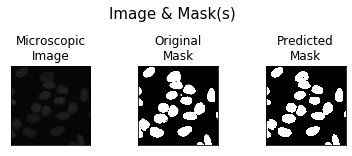

In [14]:
VisualizeImageAndMask(image = test_images[1], mask = test_masks[1], prediction_img = predicted_masks[1])

#### Viz 2

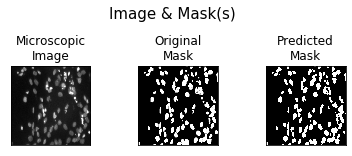

In [15]:
VisualizeImageAndMask(image = test_images[3], mask = test_masks[3], prediction_img = predicted_masks[3])

#### Viz 3

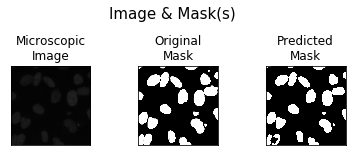

In [16]:
VisualizeImageAndMask(image = test_images[6], mask = test_masks[6], prediction_img = predicted_masks[6])